# Información y Programación Financiera, TI, Algoritmos y Ciencia de Datos

Neftalí Valdez

<a href="http://twitter.com/neftalivldz" target="_blank">@neftalivldz</a> | <a href="mailto:nvaldez@tec.mx">nvaldez@tec.mx</a>

Basado en Community Detection & Network Analysis of the Stock Market in Python & R — Part 2
<a href="https://medium.com/analytics-vidhya/community-detection-network-analysis-of-the-stock-market-in-python-r-part-2-9b5a5dbe5d5b">link</a> 

In [20]:
#%pip install pandas_datareader
#%pip install networkx
#%pip install community

In [25]:
import lseg.data as ld
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore')

from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv
from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
import math
from datetime import datetime, timedelta
import pandas_datareader.data as web

In [26]:
ld.open_session()

<lseg.data.session.Definition object at 0x30282ab50 {name='workspace'}>

In [27]:
lp4 = ld.get_data('LP40065886', ['TR.FundHoldingRIC','TR.FundHoldingName',
                           'TR.FundPercentageOfFundAssets',
                           'TR.FundNumberOfShares',
                           'TR.FundNumberOfSharesChanged'],
            {'Endnum':'5000'})

In [28]:
lp4.columns = [c.replace(' ', '_') for c in lp4.columns]
list_values = ['USD CASH', 'OTHER ASSETS LESS LIABILITIES']
portfolio = lp4[~lp4['Holding_Name'].isin(list_values)]['Holding_RIC'].to_list()
portfolio = portfolio[0:20]
portfolio

['NVDA.OQ',
 'MSFT.OQ',
 'AAPL.OQ',
 'AMZN.OQ',
 'META.OQ',
 'AVGO.OQ',
 'GOOGL.OQ',
 'TSLA.OQ',
 'GOOG.OQ',
 'BRKb.N',
 'JPM.N',
 'LLY.N',
 'V.N',
 'NFLX.OQ',
 'XOM.N',
 'ORCL.N',
 'MA.N',
 'WMT.N',
 'JNJ.N',
 'COST.OQ']

In [5]:
#portfolio = ["GOLD.N", "TSLA.O", "GOOGL.O", 'MSFT.O', 'PPG.N', 'CX.N', 'GM.N']

In [6]:
import datetime as dt
today = dt.datetime.today()
delta_day = today - dt.timedelta(days=365*10)
print(delta_day, today)

2015-10-24 17:57:37.442066 2025-10-21 17:57:37.442066


In [7]:
Precios = ld.get_history([portfolio[0]], fields = ['TR.PriceClose'],
                          start = delta_day, 
                          end = today, 
                          interval="1W")


Precios['Close'] = Precios['Price Close'].astype(float)
Precios[portfolio[0]] = np.log(Precios['Close'].div(Precios['Close'].shift(1)))
weekly_returns = Precios.drop(['Price Close', 'Close'], axis=1)
weekly_returns 


NVDA.OQ,NVDA.OQ
Date,
2015-10-30,NaN
2015-11-06,0.106241
2015-11-13,-0.057065
2015-11-20,0.051981
2015-11-27,0.000000
...,...
2025-09-19,-0.006488
2025-09-26,0.008567
2025-10-03,0.051568


In [8]:
for instrument in range(1,len(portfolio)):
    print(instrument, portfolio[instrument])
    Precios = ld.get_history([portfolio[instrument]], fields = ['TR.PriceClose'],
                          start = delta_day, 
                          end = today, 
                          interval="1W")
    Precios['Close'] = Precios['Price Close'].astype(float)
    Precios[portfolio[instrument]] = np.log(Precios['Close'].div(Precios['Close'].shift(1)))
    Precios = Precios.drop(['Price Close', 'Close'], axis=1)
    weekly_returns = weekly_returns.join(Precios)

1 MSFT.OQ
2 AAPL.OQ
3 AMZN.OQ
4 META.OQ
5 AVGO.OQ
6 GOOGL.OQ
7 TSLA.OQ
8 GOOG.OQ
9 BRKb.N
10 JPM.N
11 LLY.N
12 V.N
13 NFLX.OQ
14 XOM.N
15 ORCL.N
16 MA.N
17 WMT.N
18 JNJ.N
19 COST.OQ


In [9]:
weekly_returns

,NVDA.OQ,MSFT.OQ,AAPL.OQ,AMZN.OQ,META.OQ,AVGO.OQ,GOOGL.OQ,TSLA.OQ,GOOG.OQ,BRKb.N,JPM.N,LLY.N,V.N,NFLX.OQ,XOM.N,ORCL.N,MA.N,WMT.N,JNJ.N,COST.OQ
Date,,,,,,,,,,,,,,,,,,,,
2015-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-06,0.106241,0.042401,0.012970,0.052094,0.049038,0.051752,0.032305,0.115907,0.031777,0.002276,0.063468,-0.013701,0.014969,0.051081,0.020693,0.044810,0.025040,0.026549,0.008771,-0.003611
2015-11-13,-0.057065,-0.038609,-0.074756,-0.026152,-0.029806,-0.098214,-0.028677,-0.114652,-0.023106,-0.032580,-0.043284,-0.011374,-0.008160,-0.095705,-0.078406,-0.085267,-0.046792,-0.040978,-0.020219,-0.024935
2015-11-20,0.051981,0.025228,0.060111,0.039828,0.031905,0.072673,0.048696,0.060037,0.053759,0.034778,0.029754,0.060011,0.026281,0.177971,0.021408,0.053248,0.026891,0.062687,0.025698,0.059556
2015-11-27,0.000000,-0.004809,-0.012568,0.007170,-0.017578,0.028391,-0.006495,0.051382,-0.008415,-0.014746,-0.005493,-0.009755,-0.004374,0.012837,0.017886,-0.004075,-0.008377,-0.003001,-0.001074,0.002939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-19,-0.006488,0.015625,0.047677,0.014490,0.029716,-0.042372,0.056198,0.073341,0.055832,-0.001804,0.025319,-0.004511,0.006402,0.031906,0.005867,0.054870,0.006440,-0.011272,-0.010558,-0.017446
2025-09-26,0.008567,-0.012571,0.039769,-0.051866,-0.045510,-0.030644,-0.032641,0.033080,-0.032087,0.014463,0.004058,-0.037186,-0.012489,-0.013423,0.038259,-0.085169,-0.033119,0.008078,0.019781,-0.037721
2025-10-03,0.051568,0.011450,0.009971,-0.001229,-0.045652,0.011413,-0.004838,-0.024294,-0.002958,-0.002563,-0.019263,0.147710,0.036296,-0.048480,-0.034366,0.009410,0.026748,-0.010622,0.048496,-0.000622


In [10]:
# Se identifican activos que no tengan la historia de rendimientos completa
s = weekly_returns.isnull().apply(sum, axis=0) # count the number of nan in each column
for col in weekly_returns: 
   if s[col] >= 2:  
       del weekly_returns[col]

In [11]:
df_stock_prices = weekly_returns.dropna()
df_stock_prices

,NVDA.OQ,MSFT.OQ,AAPL.OQ,AMZN.OQ,META.OQ,AVGO.OQ,GOOGL.OQ,TSLA.OQ,GOOG.OQ,BRKb.N,JPM.N,LLY.N,V.N,NFLX.OQ,XOM.N,ORCL.N,MA.N,WMT.N,JNJ.N,COST.OQ
Date,,,,,,,,,,,,,,,,,,,,
2015-11-06,0.106241,0.042401,0.012970,0.052094,0.049038,0.051752,0.032305,0.115907,0.031777,0.002276,0.063468,-0.013701,0.014969,0.051081,0.020693,0.044810,0.025040,0.026549,0.008771,-0.003611
2015-11-13,-0.057065,-0.038609,-0.074756,-0.026152,-0.029806,-0.098214,-0.028677,-0.114652,-0.023106,-0.032580,-0.043284,-0.011374,-0.008160,-0.095705,-0.078406,-0.085267,-0.046792,-0.040978,-0.020219,-0.024935
2015-11-20,0.051981,0.025228,0.060111,0.039828,0.031905,0.072673,0.048696,0.060037,0.053759,0.034778,0.029754,0.060011,0.026281,0.177971,0.021408,0.053248,0.026891,0.062687,0.025698,0.059556
2015-11-27,0.000000,-0.004809,-0.012568,0.007170,-0.017578,0.028391,-0.006495,0.051382,-0.008415,-0.014746,-0.005493,-0.009755,-0.004374,0.012837,0.017886,-0.004075,-0.008377,-0.003001,-0.001074,0.002939
2015-12-04,0.072491,0.036056,0.010302,-0.000921,0.006899,0.126393,0.009335,-0.005325,0.021819,0.013648,0.010662,0.034889,0.006990,0.042835,-0.029611,-0.000511,0.000304,-0.003848,0.005650,0.019493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-19,-0.006488,0.015625,0.047677,0.014490,0.029716,-0.042372,0.056198,0.073341,0.055832,-0.001804,0.025319,-0.004511,0.006402,0.031906,0.005867,0.054870,0.006440,-0.011272,-0.010558,-0.017446
2025-09-26,0.008567,-0.012571,0.039769,-0.051866,-0.045510,-0.030644,-0.032641,0.033080,-0.032087,0.014463,0.004058,-0.037186,-0.012489,-0.013423,0.038259,-0.085169,-0.033119,0.008078,0.019781,-0.037721
2025-10-03,0.051568,0.011450,0.009971,-0.001229,-0.045652,0.011413,-0.004838,-0.024294,-0.002958,-0.002563,-0.019263,0.147710,0.036296,-0.048480,-0.034366,0.009410,0.026748,-0.010622,0.048496,-0.000622


In [12]:
df_stock_prices.columns

Index(['NVDA.OQ', 'MSFT.OQ', 'AAPL.OQ', 'AMZN.OQ', 'META.OQ', 'AVGO.OQ',
       'GOOGL.OQ', 'TSLA.OQ', 'GOOG.OQ', 'BRKb.N', 'JPM.N', 'LLY.N', 'V.N',
       'NFLX.OQ', 'XOM.N', 'ORCL.N', 'MA.N', 'WMT.N', 'JNJ.N', 'COST.OQ'],
      dtype='object')

In [13]:
stocks = df_stock_prices.columns


In [14]:
n_obs, n_assets = df_stock_prices.shape
n_assets, n_obs

(20, 520)

In [15]:
# Function to calculate corr
def calculate_corr(df_stock_returns, returns_window, corr_window_size, corr_method):
    stocks_cross_corr_dict = {}
    #Calculate mean correlation by window for plot
    x_days = []
    y_mean_corr = []        
#     W = corr_window_size
    for i in range(returns_window,len(df_stock_returns),corr_window_size):
        dic_key = i
        stocks_cross_corr_dict[dic_key]=df_stock_returns.iloc[i:(i+W)].corr(method='pearson')
        stocks_cross_corr_dict[dic_key].fillna(0,inplace=True)
        x_days.append(dic_key)
        y_mean_corr.append(np.mean([abs(j) for j in stocks_cross_corr_dict[dic_key].values.flatten().tolist()]))        
    return stocks_cross_corr_dict, x_days,y_mean_corr

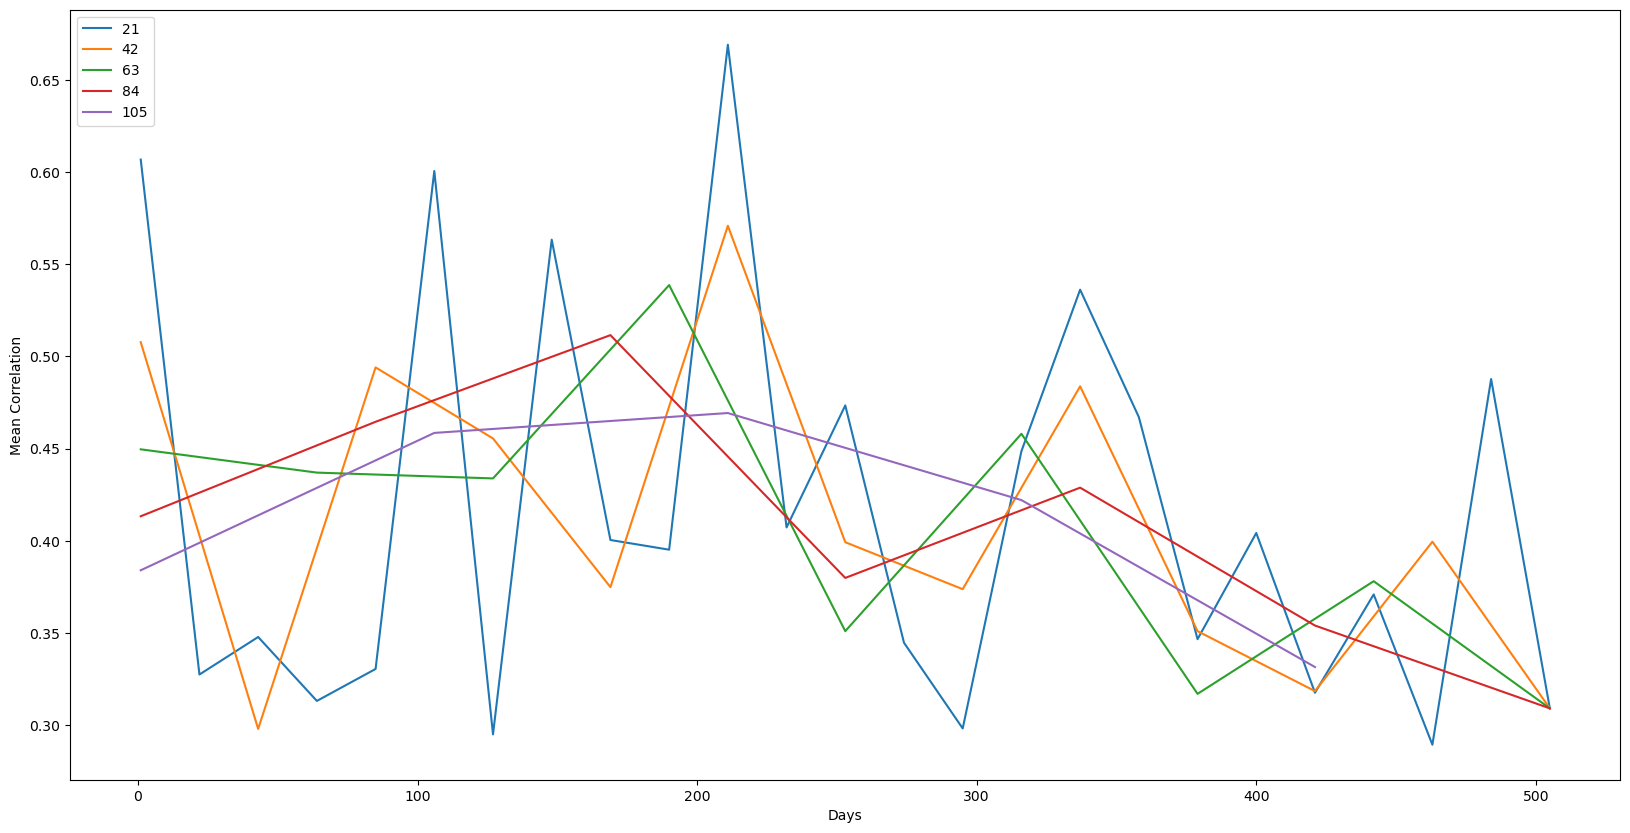

In [16]:
%matplotlib inline
# stocks_cross_corr_dict = {}
#Time Window width
#TO DO: try different windows and different algorithms
#t= 21 #21 based on the paper Asset trees and asset graphs in financial markets J.-P. Onnela et all
# Try window from 1 month to 6 months of trading days
# 21 days is one month trading days
start = 21
end = 126
step = 21;
plt.figure(figsize=(20, 10))
#Find corr for the entire time period 
# _, x_days, y_mean_corr = calculate_corr(df_stock_prices,1,len(df_stock_prices), 'pearson')
# x_days_t = range(0,len(df_stock_prices), 1)
# y_mean_corr_t = np.empty(len(df_stock_prices))
# y_mean_corr_t.fill(y_mean_corr[0])
# plt.plot(x_days_t, y_mean_corr_t)
for t in range(start, end, step):
    x_days = []
    y_mean_corr = []
    W = t
    _, x_days, y_mean_corr = calculate_corr(df_stock_prices,1,W, 'pearson')
    plt.plot(x_days, y_mean_corr)
    plt.xlabel('Days')
    plt.ylabel('Mean Correlation')
    l = list(range(start, end, step))
#     l.insert(0, len(df_stock_prices))
    plt.legend(l, loc='upper left')     

plt.show()

In [17]:
#Calculate corr for the entire period.
stocks_cross_corr, _, _ = calculate_corr(df_stock_prices,1, len(df_stock_prices), 'pearson')
stocks_cross_corr[1]

,NVDA.OQ,MSFT.OQ,AAPL.OQ,AMZN.OQ,META.OQ,AVGO.OQ,GOOGL.OQ,TSLA.OQ,GOOG.OQ,BRKb.N,JPM.N,LLY.N,V.N,NFLX.OQ,XOM.N,ORCL.N,MA.N,WMT.N,JNJ.N,COST.OQ
NVDA.OQ,1.000000,0.476911,0.366420,0.403353,0.283587,0.441459,0.380330,0.376632,0.396527,0.385561,0.407088,0.207632,0.412395,0.236535,0.186249,0.290736,0.406168,0.102299,0.298994,0.334205
MSFT.OQ,0.476911,1.000000,0.493450,0.636771,0.614409,0.633025,0.812894,0.356082,0.827360,0.357664,0.367398,0.207248,0.620451,0.479438,0.098752,0.464138,0.659657,0.134980,0.374883,0.401181
AAPL.OQ,0.366420,0.493450,1.000000,0.333222,0.234177,0.624067,0.546064,0.430045,0.536712,0.316283,0.300397,0.183848,0.539616,0.467787,0.047222,0.387713,0.435214,0.272148,0.143267,0.466855
AMZN.OQ,0.403353,0.636771,0.333222,1.000000,0.586686,0.480975,0.634524,0.400447,0.643224,0.190639,0.243634,0.253206,0.496772,0.385139,0.098750,0.308985,0.552121,-0.036231,0.285813,0.307001
META.OQ,0.283587,0.614409,0.234177,0.586686,1.000000,0.465764,0.612322,0.322587,0.618772,0.258212,0.275487,0.145722,0.544452,0.273124,0.094620,0.399624,0.575792,0.151172,0.392695,0.256665
AVGO.OQ,0.441459,0.633025,0.624067,0.480975,0.465764,1.000000,0.549785,0.427309,0.565943,0.358443,0.329287,0.092989,0.570625,0.423975,0.094963,0.467435,0.472598,0.188343,0.289477,0.322832
GOOGL.OQ,0.380330,0.812894,0.546064,0.634524,0.612322,0.549785,1.000000,0.400770,0.993172,0.316159,0.337072,0.271749,0.617595,0.547373,0.084910,0.498653,0.646813,0.106311,0.340503,0.392441
TSLA.OQ,0.376632,0.356082,0.430045,0.400447,0.322587,0.427309,0.400770,1.000000,0.396823,0.239867,0.236219,0.287004,0.381746,0.385473,0.225090,0.339268,0.451531,0.074592,0.289443,0.317683
GOOG.OQ,0.396527,0.827360,0.536712,0.643224,0.618772,0.565943,0.993172,0.396823,1.000000,0.328709,0.336520,0.286604,0.619962,0.553030,0.065779,0.494891,0.638036,0.109705,0.352531,0.394088
BRKb.N,0.385561,0.357664,0.316283,0.190639,0.258212,0.358443,0.316159,0.239867,0.328709,1.000000,0.779105,0.266272,0.414750,0.213104,0.379905,0.375156,0.411946,0.197109,0.405883,0.412625


In [21]:
#Build the Graph with stocks as nodes and corr as edges
import networkx as nx
import networkx.algorithms.community as nxcom
import community

edge_weights = []
def build_graph(stocks_cross_corr, threshold):
    graph_edges = []
    for x in stocks_cross_corr.keys():
        for y in stocks_cross_corr[x].keys():
            #print(x, y) 
            # Filter by absolute value of the corr
            if abs(stocks_cross_corr[x][y]) > threshold:
                #if same stock, continue
                if  x == y:
                    continue
                if x < y: #Avoid duplicates, AxAAL vs AALxA
                    graph_edges.append([x,y,dict(weight=abs(stocks_cross_corr[x][y]))])
                    edge_weights.append(abs(stocks_cross_corr[x][y]))
                else:
                    None

In [22]:
#Community detection using Girvan Newman (GN)
stocks_cross_corr, _, _ = calculate_corr(df_stock_prices,1, len(df_stock_prices), 'pearson')
stocks_cross_corr = stocks_cross_corr[1]
cor_thresold = 0.45

In [23]:
stocks_cross_corr

,NVDA.OQ,MSFT.OQ,AAPL.OQ,AMZN.OQ,META.OQ,AVGO.OQ,GOOGL.OQ,TSLA.OQ,GOOG.OQ,BRKb.N,JPM.N,LLY.N,V.N,NFLX.OQ,XOM.N,ORCL.N,MA.N,WMT.N,JNJ.N,COST.OQ
NVDA.OQ,1.000000,0.476911,0.366420,0.403353,0.283587,0.441459,0.380330,0.376632,0.396527,0.385561,0.407088,0.207632,0.412395,0.236535,0.186249,0.290736,0.406168,0.102299,0.298994,0.334205
MSFT.OQ,0.476911,1.000000,0.493450,0.636771,0.614409,0.633025,0.812894,0.356082,0.827360,0.357664,0.367398,0.207248,0.620451,0.479438,0.098752,0.464138,0.659657,0.134980,0.374883,0.401181
AAPL.OQ,0.366420,0.493450,1.000000,0.333222,0.234177,0.624067,0.546064,0.430045,0.536712,0.316283,0.300397,0.183848,0.539616,0.467787,0.047222,0.387713,0.435214,0.272148,0.143267,0.466855
AMZN.OQ,0.403353,0.636771,0.333222,1.000000,0.586686,0.480975,0.634524,0.400447,0.643224,0.190639,0.243634,0.253206,0.496772,0.385139,0.098750,0.308985,0.552121,-0.036231,0.285813,0.307001
META.OQ,0.283587,0.614409,0.234177,0.586686,1.000000,0.465764,0.612322,0.322587,0.618772,0.258212,0.275487,0.145722,0.544452,0.273124,0.094620,0.399624,0.575792,0.151172,0.392695,0.256665
AVGO.OQ,0.441459,0.633025,0.624067,0.480975,0.465764,1.000000,0.549785,0.427309,0.565943,0.358443,0.329287,0.092989,0.570625,0.423975,0.094963,0.467435,0.472598,0.188343,0.289477,0.322832
GOOGL.OQ,0.380330,0.812894,0.546064,0.634524,0.612322,0.549785,1.000000,0.400770,0.993172,0.316159,0.337072,0.271749,0.617595,0.547373,0.084910,0.498653,0.646813,0.106311,0.340503,0.392441
TSLA.OQ,0.376632,0.356082,0.430045,0.400447,0.322587,0.427309,0.400770,1.000000,0.396823,0.239867,0.236219,0.287004,0.381746,0.385473,0.225090,0.339268,0.451531,0.074592,0.289443,0.317683
GOOG.OQ,0.396527,0.827360,0.536712,0.643224,0.618772,0.565943,0.993172,0.396823,1.000000,0.328709,0.336520,0.286604,0.619962,0.553030,0.065779,0.494891,0.638036,0.109705,0.352531,0.394088
BRKb.N,0.385561,0.357664,0.316283,0.190639,0.258212,0.358443,0.316159,0.239867,0.328709,1.000000,0.779105,0.266272,0.414750,0.213104,0.379905,0.375156,0.411946,0.197109,0.405883,0.412625


In [24]:
#stocks_cross_corr
source = []
target = []
weights = []
graph_edges = []
threshold = 0.45
G = nx.Graph()
for x in stocks_cross_corr.keys():
    for y in stocks_cross_corr[x].keys():
        #print(x, y) 
        # Filter by absolute value of the corr
        if abs(stocks_cross_corr[x][y]) > threshold:
            #if same stock, continue
            if  x == y:
                continue
            if x < y: #Avoid duplicates, AxAAL vs AALxA
                #print(stocks_cross_corr[x][y])
                source.append((x, y, abs(stocks_cross_corr[x][y])))
source

[('MSFT.OQ', 'NVDA.OQ', 0.47691112224780835),
 ('MSFT.OQ', 'V.N', 0.6204512275896539),
 ('MSFT.OQ', 'NFLX.OQ', 0.4794381356241976),
 ('MSFT.OQ', 'ORCL.N', 0.46413786876205965),
 ('AAPL.OQ', 'MSFT.OQ', 0.49344973515494656),
 ('AAPL.OQ', 'AVGO.OQ', 0.6240669631648299),
 ('AAPL.OQ', 'GOOGL.OQ', 0.5460644979665588),
 ('AAPL.OQ', 'GOOG.OQ', 0.5367120132556402),
 ('AAPL.OQ', 'V.N', 0.539615787652718),
 ('AAPL.OQ', 'NFLX.OQ', 0.46778728798078123),
 ('AAPL.OQ', 'COST.OQ', 0.4668553566963576),
 ('AMZN.OQ', 'MSFT.OQ', 0.6367711729407368),
 ('AMZN.OQ', 'META.OQ', 0.5866863380516321),
 ('AMZN.OQ', 'AVGO.OQ', 0.48097548408471474),
 ('AMZN.OQ', 'GOOGL.OQ', 0.6345243396867413),
 ('AMZN.OQ', 'GOOG.OQ', 0.6432239091906682),
 ('AMZN.OQ', 'V.N', 0.4967716534666458),
 ('AMZN.OQ', 'MA.N', 0.5521208435969249),
 ('META.OQ', 'MSFT.OQ', 0.6144086082378778),
 ('META.OQ', 'V.N', 0.5444516306332301),
 ('AVGO.OQ', 'MSFT.OQ', 0.6330251738413122),
 ('AVGO.OQ', 'META.OQ', 0.46576424884862855),
 ('AVGO.OQ', 'GOOGL.OQ'

In [60]:
G = nx.Graph()
G.add_weighted_edges_from(source)

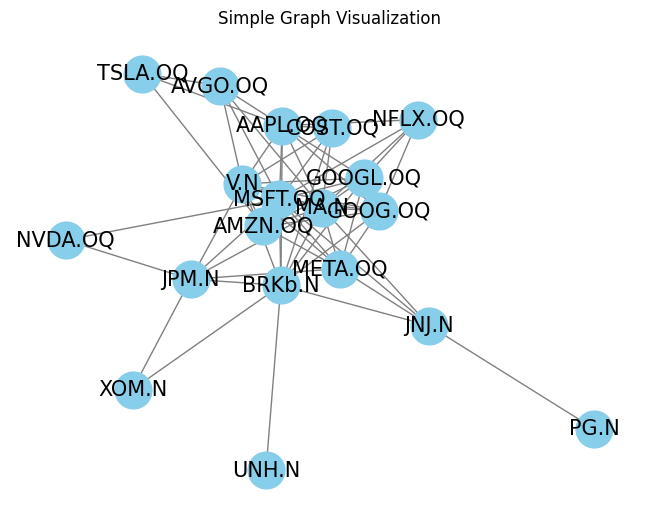

In [61]:
# Draw the graph
nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, font_size=15, font_color='black', edge_color='gray')
plt.title("Simple Graph Visualization")
plt.show()


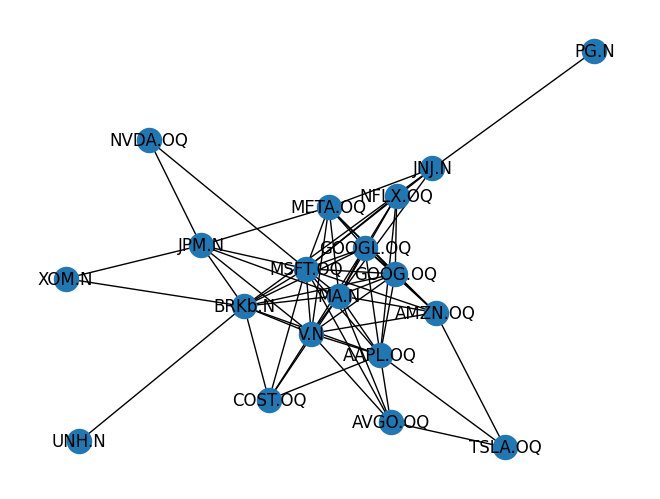

<Figure size 50000x10000 with 0 Axes>

In [62]:
nx.draw(G, with_labels = True)
# Create a new figure with a specific size
plt.figure(figsize=(500, 100))  # Width: 10 inches, Height: 6 inches

plt.show()

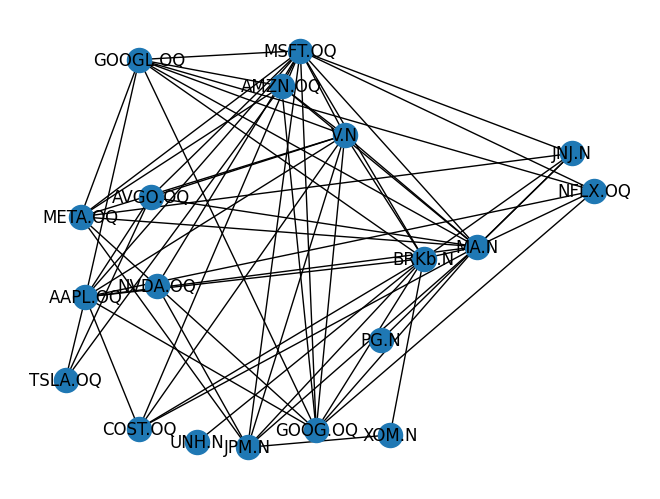

In [63]:
# clearing the current plot
plt.clf()
 
# drawing in planar layout
nx.draw_random(G, with_labels = True)
plt.show()

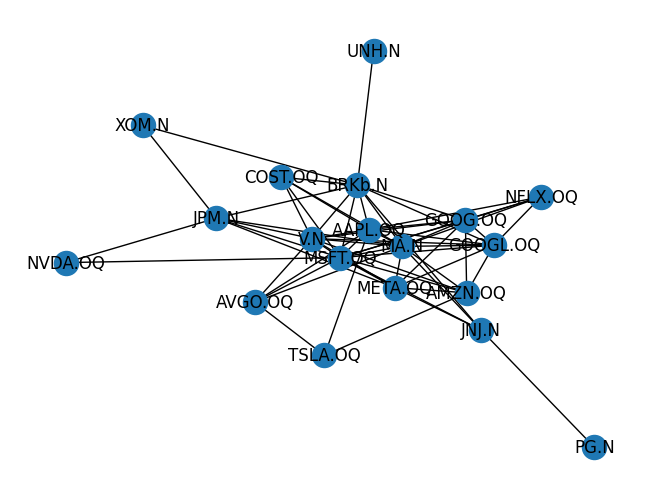

In [64]:
# clearing the current plot
plt.clf()
 
# drawing in spectral layout
nx.draw_spring(G, with_labels = True)
plt.show()

IndexError: list index out of range

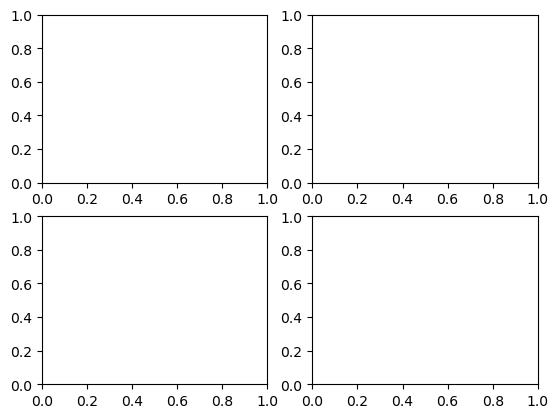

In [29]:
import math

import matplotlib.pyplot as plt
import networkx as nx

n = 150  # 150 nodes
# p value at which giant component (of size log(n) nodes) is expected
p_giant = 1.0 / (n - 1)
# p value at which graph is expected to become completely connected
p_conn = math.log(n) / n

# the following range of p values should be close to the threshold
pvals = [0.003, 0.006, 0.008, 0.015]

fig, axes = plt.subplots(2, 2)
for p, ax, seed in zip(pvals, axes.ravel(), range(len(pvals))):
    #### generate graph ####
    #G = nx.binomial_graph(n, p, seed=seed)
    # identify connected/disconnected nodes
    connected = [n for n, d in G.degree() if d > 0]
    disconnected = list(set(G.nodes()) - set(connected))
    # identify largest connected component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    #### draw graph ####
    pos = nx.nx_agraph.graphviz_layout(G)
    ax.set_title(f"p = {p:.3f}")
    # draw largest connected component
    options = {"ax": ax, "edge_color": "tab:red"}
    nx.draw_networkx_edges(G0, pos, width=6.0, **options)
    # draw other connected components
    for Gi in Gcc[1:]:
        if len(Gi) > 1:
            nx.draw_networkx_edges(G.subgraph(Gi), pos, alpha=0.3, width=5.0, **options)
    # draw connected/disconnected nodes
    options = {"ax": ax, "node_size": 30, "edgecolors": "white"}
    nx.draw(G, pos, nodelist=connected, **options)
    nx.draw(G, pos, nodelist=disconnected, alpha=0.25, **options)
fig.tight_layout()
plt.show()